# <center>  **<span style="font-size:80px;">Clustering</span>** </center>

# <center> Universidad de Alicante </center>
<p align="center"><img src=".ipynb_gfx/UA.png" width="330" height="190"></p>
<br>

**Nombre:** Santiago Álvarez Geanta <br>
**Fecha:** 14 de marzo de 2025 <br>
**Grado:** Ingeniería en Inteligencia Artificial <br>
**Grupo:** 1 <br>


### Profesores
- Francisco Escolano Ruíz
- Ahmed Begga Hachlafi
<br>

## Librerías utilizadas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy import ndimage

# Ejercicio 1

In [2]:
def generarDatosGaussianos(NUM_MUESTRAS=100, NUM_CLUSTERS=3, centros=None, varianza=0.5):
    """
    param:

    centros: lista con las coordenadas de cada centro
    """
    
    X = list() # X: Dimension (NUM_MUESTRAS x 2): NUM_MUESTRAS puntos x 2 coordenadas (x, y)
    y = list() # y: Dimensión (NUM_MUESTRAS x 1): NUM_MUESTRAS puntos x 1 etiqueta
    
    for i in range(NUM_CLUSTERS):
        centro = centros[i]

        # Generamos los valores que siguen una distribución normal 
        x_points = np.random.normal(loc= centro[0], scale=varianza, size=NUM_MUESTRAS) 
        y_points = np.random.normal(loc= centro[1], scale=varianza, size=NUM_MUESTRAS) 

        # Generamos las etiquetas para cada valor (cada etiqueta representa un cluster al que pertenece)
        etiquetas = np.full(NUM_MUESTRAS, i)

        # Nos inventamos una dimensión ficticia (ambas son de m x 1) para obtener una lista de m x 2
        point = np.concatenate((x_points[:, None], y_points[:, None]), axis=1)
        
        X.append(point)
        y.append(etiquetas)
    
    # Usamos np.(v/h)stack: de esta forma en vez de tener NUM_CLUSTERS arrays
    # tenemos UN SOLO solo array con los NUM_CLUSTERS arrays todos juntos
    # v: vertical, h: horizontal
    X = np.vstack(X) 
    y = np.hstack(y)

    return X, y

In [3]:
def visual(X, y, centros, NUM_CLUSTERS):
    plt.figure(figsize=(11, 7))
    colors = ["red", "green", "blue", "cyan", "magenta", "yellow"]
    colors = colors[:NUM_CLUSTERS]

    for i, c in enumerate(colors):
        mask = (y==i) # filtramos por aquellos que pertenecen (etiqueta y) al cluster (i)
        
        # Puntos
        plt.scatter(x= X[mask, 0], y= X[mask, 1], 
                    color= c, alpha=0.55, s=40, 
                    label= f"Cluster {i+1}")
        

    plt.scatter(x=[c[0] for c in centros], y=[c[1] for c in centros],
                color="black", marker="x", s=70,
                label="Centro clusters")
    
    plt.legend()
    plt.show()

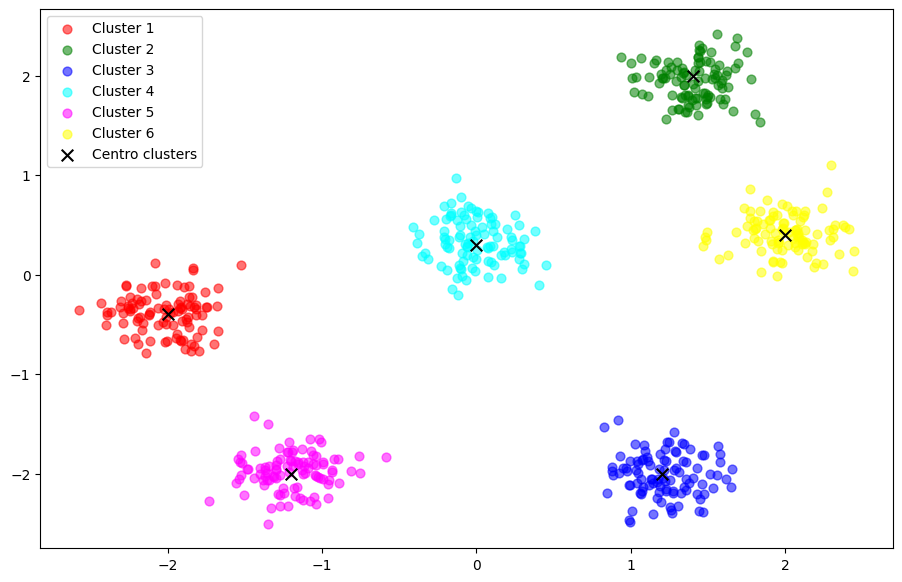

In [4]:
centros= [[-2, -0.4], [1.4, 2], [1.2, -2], [0, 0.3], [-1.2, -2], [2, 0.4]]
NUM_CLUSTERS = len(centros)

X, y = generarDatosGaussianos(centros= centros, NUM_CLUSTERS= NUM_CLUSTERS, varianza=0.2)
visual(X= X, y= y, centros= centros, NUM_CLUSTERS= NUM_CLUSTERS)

# Ejercicio 2

In [5]:
class DeterministicAnnealing:
    def __init__(self, n_clusters=3, T_min=0.01, T_max=5.0, epsilon=1e-6, max_iter=100, alpha= 1):
        """
        Implementación del algoritmo Deterministic Annealing para clustering.
        
        Parámetros:
        -----------
        n_clusters : int
            Número de clusters a encontrar
        T_min : float
            Temperatura mínima para detener el enfriamiento
        T_max : float
            Temperatura inicial
        epsilon : float
            Umbral de convergencia para la matriz de pertenencia
        max_iter : int
            Número máximo de iteraciones
        """
        self.n_clusters = n_clusters
        self.T_min = T_min
        self.T_max = T_max
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.alpha = alpha
        self.centroids = None
        self.M = None  # Matriz de pertenencia
    
    def _calcular_distancia(self, X, centroides):
        """
        Calcula la matriz de distancias euclidianas al cuadrado entre puntos y centroides.
        
        Utilizamos la identidad: ||a-b||² = ||a||² + ||b||² - 2<a,b>
        donde <a,b> es el producto escalar.
        """
        
        # Shape = (i, j)
        # Al hacer la suma nos queda (i, ) -> al usar keepdims -> (i, 1)
        norma_X = np.sum(X**2, axis=1, keepdims=True)
        norma_centroides = np.sum(centroides**2, axis=1, keepdims=True)
        producto_escalar = np.dot(X, centroides.T) # np.dot hace multiplicación de filas (por eso usamos transpuesta)
        distancias = norma_X + norma_centroides.T - 2 * producto_escalar
      
        return np.maximum(distancias, 0)
    
    def _actualizar_pertenencia(self, X, centroides, T):
        """
        Actualiza la matriz de pertenencia (probabilidades).
        
        Esta es la parte clave del algoritmo deterministic annealing:
        la probabilidad de pertenencia depende de la distancia y la temperatura.
        """
        beta = 1/T
        D = self._calcular_distancia(X, centroides)
        numerador = np.exp(-beta * D)
        denominador = np.sum(numerador, axis=1, keepdims=True) + 1e-10 # 1e-10 para que nunca sea 0
    
        return numerador / denominador
    
    def _actualizar_centroides(self, X, M):
        """
        Actualiza las posiciones de los centroides basado en la matriz de pertenencia.
        
        Cada centroide se actualiza como un promedio ponderado de todos los puntos,
        donde los pesos son las probabilidades de pertenencia.
        """
        return (M.T @ X) / np.sum(M, axis=0, keepdims=True).T
    
    def fit(self, X):
        """
        Ajusta el modelo de Deterministic Annealing a los datos.
        
        Proceso:
        1. Inicializar centroides y temperatura
        2. Bucle principal de annealing:
           - Calcular matriz de pertenencia
           - Actualizar centroides
           - Reducir temperatura
           - Verificar convergencia
        """
        n_muestras, n_dimensiones = X.shape
                

        # Iniciamos con el bariocentro de los datos
        #self.centroids = np.mean(X, axis=0, keepdims=True)
        #self.centroids = np.repeat(self.centroids, self.n_clusters, axis=0)
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        
        # Inicializar parámetros para el bucle
        t = 0  # Contador de iteraciones
        T = self.T_max  # Temperatura inicial
        convergencia = False
        M_anterior = np.ones((n_muestras, self.n_clusters)) / self.n_clusters
        
        # Bucle principal
        while not convergencia:
            # Actualizar matriz de pertenencia con temperatura actual
            self.M = self._actualizar_pertenencia(X, self.centroids, T)

            # Actualizar centroides
            self.centroids = self._actualizar_centroides(X, self.M)
            
            # Actualizar contador y temperatura
            t += 1
            T = 1 / np.log(1 + t)
            T *= self.alpha # Determina que tan rápido (alpha < 1) o lento (alpha > 1) decrece la temperatura
            
            # Verificar convergencia
            if T <= self.T_min or t >= self.max_iter or np.sum(np.abs(self.M - M_anterior)) <= self.epsilon:
                convergencia = True
            
            # Guardar matriz actual para próxima iteración
            M_anterior = self.M.copy()

        
        return self
    
    def predict(self, X):
        """
        Predice el cluster para cada punto en X.
        
        Retorna el índice del cluster con mayor probabilidad para cada punto.
        """
        M = self._actualizar_pertenencia(X, self.centroids, self.T_min)
        return np.argmax(M, axis=1)
    
    def fit_predict(self, X):
        """
        Ajusta el modelo y predice los clusters en un solo paso.
        """
        self.fit(X)
        return self.predict(X)
    
    def calcular_entropia_por_puntos(self):
        return -1 / len(self.M) * np.sum(self.M * np.log(self.M)) 
    
       # Calcular la entropía total para este número de clusters
    def calcular_entropia_por_cluster(self):
        lista_entropias = list()
        entropia_total = 0
        for i in range(self.n_clusters):
            p_c =  np.sum(self.M[:, i]) / len(self.M) 
            p_x_dado_c = self.M[:, i] / np.sum(self.M[:, i])
            entropia_cluster = -np.sum(p_x_dado_c * np.log(p_x_dado_c + 1e-10))


            entropia_total = p_c * entropia_cluster
            lista_entropias.append(entropia_cluster)
        return entropia_total, np.array(lista_entropias)

# Función principal

In [6]:
def main(configuraciones, T_alpha=1, NUM_MUESTRAS=100, max_iter=100, varianza=1, figname=None, plot= True, extra_title=""):
    
    resultados = []

    for num_clusters, num_clusters_modelo in configuraciones:
        np.random.seed(42)
        centros = np.random.uniform(-1, 1, size=(num_clusters, 2))
        
        X, y = generarDatosGaussianos(NUM_MUESTRAS= NUM_MUESTRAS, NUM_CLUSTERS=num_clusters, centros=centros, varianza= varianza)
        modelo = DeterministicAnnealing(n_clusters=num_clusters_modelo, alpha= T_alpha, max_iter= max_iter)
        y_pred = modelo.fit_predict(X)
        
        resultados.append((X, y_pred, num_clusters, num_clusters_modelo, modelo.centroids))
    
    # Graficamos los resultados
    n = len(resultados)
    cols = int(n**0.5)
    if cols * cols < n:
        cols += 1
    rows = (n + cols - 1) // cols  


    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.ravel()
    else:
        axes = np.array([axes])


    for i, (X, y_pred, num_clusters, num_clusters_modelo, centroids) in enumerate(resultados):
        axes[i].scatter(X[:, 0], X[:, 1], c=y_pred, cmap= 'viridis', alpha=0.6)
        axes[i].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroides')
        axes[i].set_title(f"Datos con {num_clusters} clusters\nAlgoritmo con {num_clusters_modelo} clusters")
        axes[i].legend()
        axes[i].grid()

    if extra_title:
        fig.suptitle(extra_title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig("report_gfx/"+ figname + ".png")

    if plot:
        plt.show()
    else:
        plt.close()

# Ejercicio 3

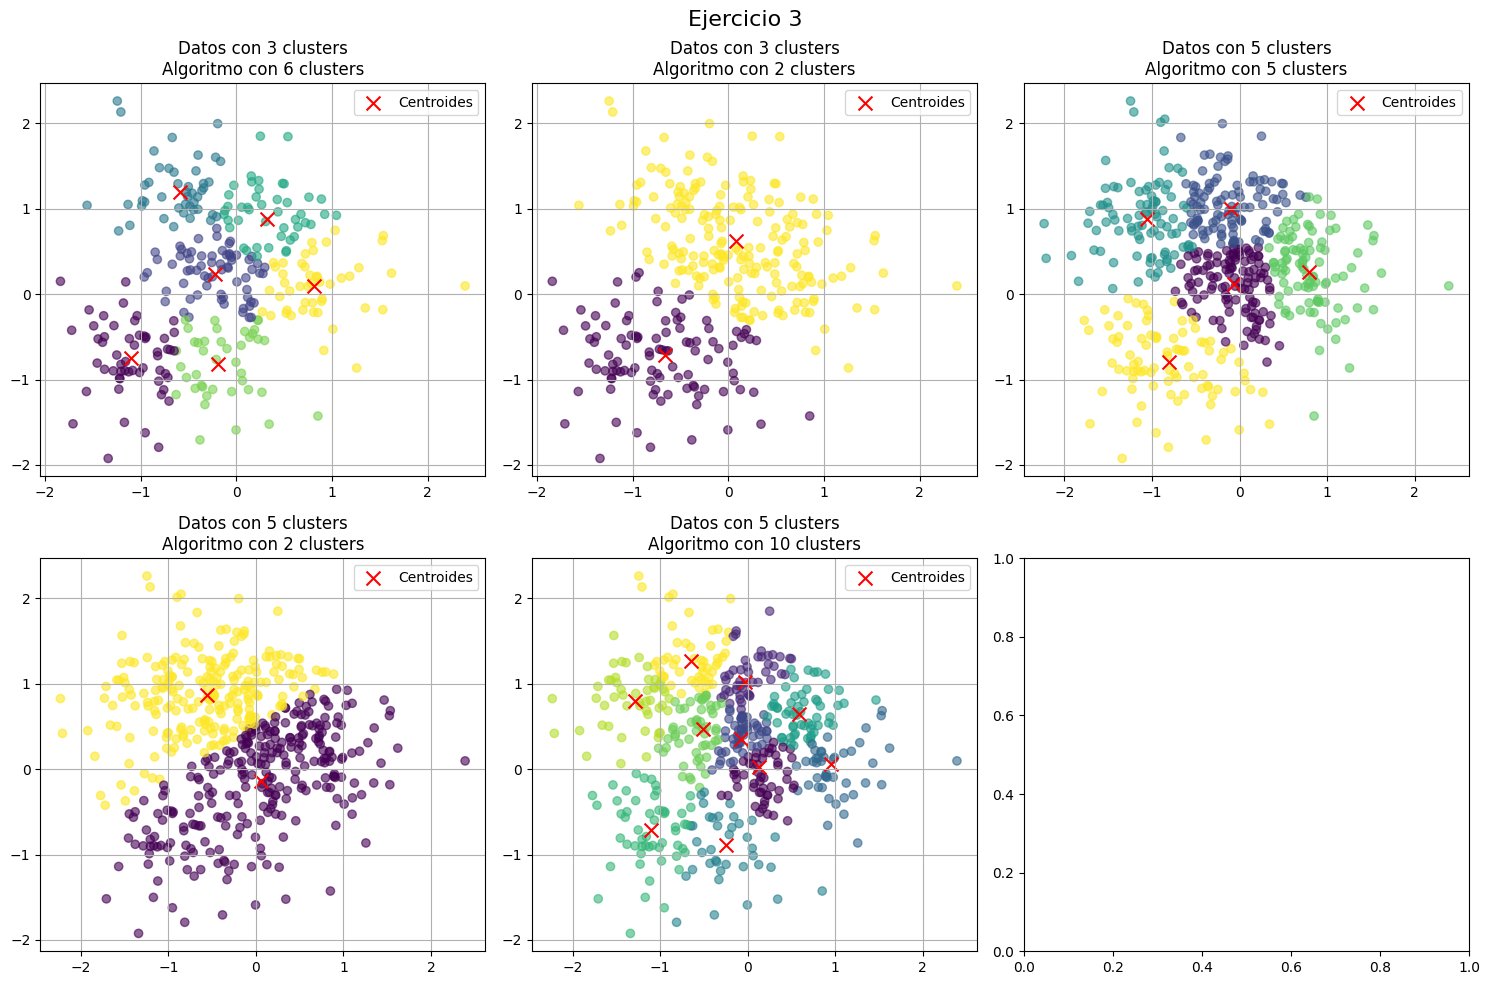

In [7]:
configuraciones = [
    (3, 6), (3, 2), (5, 5), (5, 2), (5, 10)
]

main(configuraciones, extra_title= "Ejercicio 3", NUM_MUESTRAS=100, varianza=0.5, figname= "E3")

# Ejercicio 5

In [8]:
def find_optimal_cluster(X, cluster_min=1, cluster_max=10, plot=True, umbral_mejora=0.1, figname="image"):

    lista_entropias = []
    clusters = list(range(cluster_min, cluster_max + 1))

    # Probamos los posibles clusters
    for cluster in clusters:
        modelo = DeterministicAnnealing(n_clusters=cluster)
        modelo.fit(X)

        # Obtenemos la entropía con un cluster en concreto
        entropia_total, _ = modelo.calcular_entropia_por_cluster()
        lista_entropias.append(entropia_total)

    # Calculamos cuánto mejoró la entropía (como si calculasemos un "error relativo")
    lista_mejoras = []
    for i in range(1, len(lista_entropias)):
        mejora_relativa = (lista_entropias[i-1] - lista_entropias[i]) / (lista_entropias[i-1] + 1e-10)
        lista_mejoras.append(mejora_relativa)

    # Clasificamos cuál obutvo la mayor mejora
    mejor_cluster = cluster_min
    for i in range(1, len(lista_mejoras)):
        if lista_mejoras[i] < umbral_mejora:
            mejor_cluster = clusters[i]
            break
    else:
        mejor_cluster = clusters[np.argmin(lista_entropias)]

  
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(clusters, lista_entropias, 'bo-', label='Entropía total')
        plt.axvline(x=mejor_cluster, color='red', linestyle='--', label=f'k óptimo = {mejor_cluster}')

        plt.xlabel("Número de clusters")
        plt.ylabel("Entropía total")
        plt.title("Método del Codo basado en Entropía")
        plt.legend()
        plt.grid(True)
        plt.savefig(figname + ".png")

        plt.show()
        



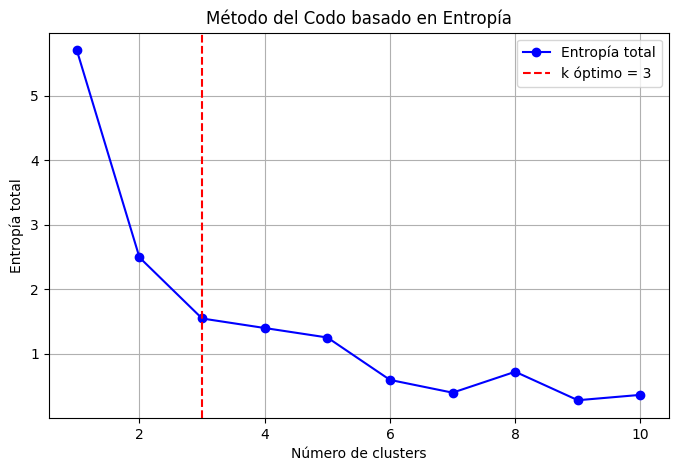

Número óptimo de clusters: None


In [9]:
NUM_MUESTRAS = 100
centros = [[0, 0], [0.1, 0.1], [0.2, 0.2]]
NUM_CLUSTERS = len(centros)
varianza = 1

X, y = generarDatosGaussianos(NUM_MUESTRAS= NUM_MUESTRAS, NUM_CLUSTERS=NUM_CLUSTERS, centros=centros, varianza= varianza)
k_opt = find_optimal_cluster(X, cluster_min=1, cluster_max=10, figname=f"./report_gfx/Elbow_near_centers3")
print("Número óptimo de clusters:", k_opt)



# Ejercicio 6

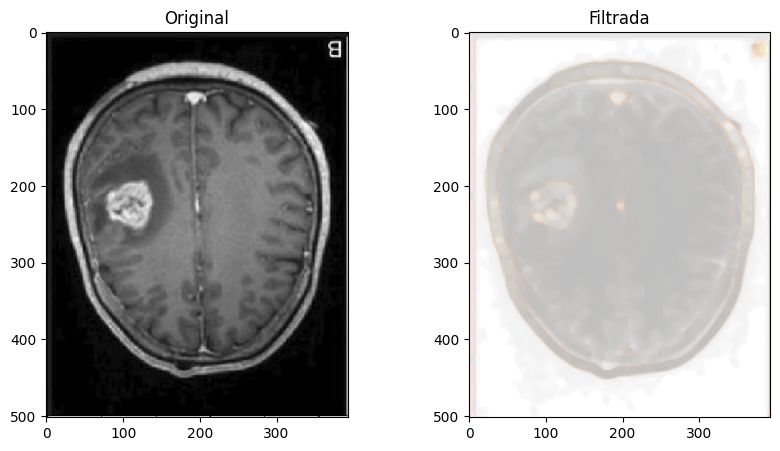

Shape de la imagen original: (502, 393, 4)
Shape de la imagen reformateada: (263048, 3)


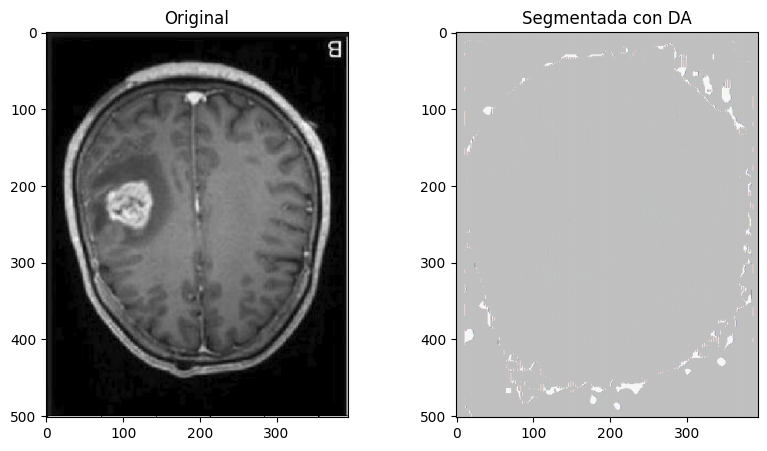

In [10]:
# Fijamos las semillas para reproducibilidad
np.random.seed(42)
# 1. Cargar una imagen
image = np.array(Image.open('Tumor1.png'))

# 2. Preprocesamiento (opcional)
# Aplicar un filtro de mediana para reducir el ruido, cuando decimos ruido nos referimos a que haya demasiada variación en los colores de los píxeles
# en la imagen. Esto puede ayudar a mejorar la segmentación.
image_filtered = ndimage.median_filter(image, size=10) # ndimage.median_filter es una función de SciPy que aplica un filtro de mediana a la imagen. Le pasamos la imagen y el tamaño del filtro (10x10 píxeles en este caso). Esto significa que cada píxel en la imagen filtrada es reemplazado por la mediana de los píxeles en una vecindad de 10x10 píxeles alrededor de él.
# 2.1 Mostramos la imagen original y la imagen filtrada
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image), plt.title('Original')
plt.subplot(122), plt.imshow(image_filtered), plt.title('Filtrada')
plt.show()
# 3. Reformatear la imagen para clustering
print("Shape de la imagen original:", image.shape)
pixel_values = image_filtered.reshape((-1, 3))
print("Shape de la imagen reformateada:", pixel_values.shape)
pixel_values = np.float32(pixel_values)

# 4. Aplicar Deterministic Annealing
modelo = DeterministicAnnealing(n_clusters=5)
y_pred = modelo.fit_predict(pixel_values)
segmented_image = modelo.centroids[y_pred].reshape(image.shape).astype(np.uint8)


# 5. Visualizar los resultados
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(image), plt.title('Original')
plt.subplot(132), plt.imshow(segmented_image), plt.title('Segmentada con DA')
plt.show()

# Testing utilizado en el Report

In [11]:
# Descenso de Temperaturas (variando α)
configuraciones = [(5, 10)]

main(configuraciones, extra_title= "Descenso Normal de Temperatura (α=1)", NUM_MUESTRAS=200, varianza=0.5, figname= "NormalTemperature", plot= False)
main(configuraciones, extra_title= "Descenso Rápido de Temperatura (α=1e-10)", NUM_MUESTRAS=200, T_alpha=1e-10, varianza=0.5, figname= "FastTemperature", plot= False)
main(configuraciones, extra_title= "Descenso Lento de Temperatura (α=1e+10)", NUM_MUESTRAS=200, T_alpha=1e+10, varianza=0.5, figname= "SlowTemperature", plot= False)

In [12]:
# Inicialización de Clusters (variando α)
configuraciones = [(5, 5)]

#main(configuraciones, extra_title= "Inicialización Aleatoria de Clusters", NUM_MUESTRAS=200, varianza=0.5, figname= "AleatoryInit", plot= False)
#main(configuraciones, extra_title= "Inicialización Baricentro de Clusters", NUM_MUESTRAS=200, varianza=0.5, figname= "BaricenterInit", plot= False)

In [13]:
# Número de iteraciones máximas
configuraciones = [(10, 10)]

main(configuraciones, extra_title= "5 - Iteraciones de Convergencia", NUM_MUESTRAS=200, max_iter=5, varianza=0.5, figname= "LowIterations", plot= False)
main(configuraciones, extra_title= "10 000 - Iteraciones de Convergencia", NUM_MUESTRAS=200, max_iter=10_000, varianza=0.5, figname= "HighIterations", plot= False)

In [14]:
# Varianza
configuraciones = [(30, 30), (10, 10)]

main(configuraciones, extra_title= "Varianza = 0.1", NUM_MUESTRAS=200,  varianza=0.1, figname= "LowStd", plot= False)
main(configuraciones, extra_title= "Varianza = 1", NUM_MUESTRAS=200, varianza=1, figname= "NormalStd", plot= False)
main(configuraciones, extra_title= "Varianza = 10", NUM_MUESTRAS=200, varianza=10, figname= "HighStd", plot= False)
main(configuraciones, extra_title= "Varianza = 100", NUM_MUESTRAS=200, varianza=100, figname= "VeryHighStd", plot= False)